## Common

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical


def layer_init(layer, scale=1.0):
    nn.init.orthogonal_(layer.weight.data)
    layer.weight.data.mul_(scale)
    nn.init.constant_(layer.bias.data, 0)
    return layer

class FCNet(nn.Module):
    """Fully Connected Model."""
    def __init__(self, state_size, seed, hidden_layers, use_reset, act_fnc=F.relu):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            seed (int): Random seed
            hidden_layers (list): Size of hidden_layers
            act_fnc : Activation function
            use_reset (bool): Weights initialization
        """
        super(FCNet, self).__init__()
        self.seed = torch.manual_seed(seed)
        dims = [state_size, ] + hidden_layers
        if use_reset:
            self.layers = nn.ModuleList([layer_init(nn.Linear(in_put, out_put)) for in_put, out_put in zip(dims[:-1], dims[1:])])
        else:
            self.layers = nn.ModuleList([nn.Linear(in_put, out_put) for in_put, out_put in zip(dims[:-1], dims[1:])])
        self.act_fuc = act_fnc
        self.feature_dim = dims[-1]

    def forward(self, x):
        for layer in self.layers:
            x = self.act_fuc(layer(x))
        return x


class ConvNet(nn.Module):
    """Convolution Model for raw pixels."""
    def __init__(self, state_size, feature_dim, seed, use_reset=True, input_channel=4):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            feature_dim (int): Feature dimension
            seed (int): Random seed
            use_reset (bool): Weights initialization
            input_channel (int): Channel number of input
        """
        super(ConvNet, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.size1 = ((state_size-6)//2+1)  # 80x80x4 to 38x38x4
        self.size2 = ((self.size1-6)//4+1)  # 38x38x4 to 9x9x16
        self.size = self.size2**2*16
        self.feature_dim = feature_dim

        if use_reset:
            self.conv1 = layer_init(nn.Conv2d(input_channel, 4, kernel_size=6, stride=2))
            self.conv2 = layer_init(nn.Conv2d(4, 16, kernel_size=6, stride=4))
            self.fc3 = layer_init(nn.Linear(self.size, feature_dim))
        else:
            self.conv1 = nn.Conv2d(input_channel, 4, kernel_size=6, stride=2)
            self.conv2 = nn.Conv2d(4, 16, kernel_size=6, stride=4)
            self.fc3 = nn.Linear(self.size, feature_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1,self.size)
        x = F.relu(self.fc3(x))
        return x


class Policy(nn.Module):
    """Actor Critic Model (shared weights)"""
    def __init__(self, state_size, action_size, seed, main_net):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            main_net (model): Common net for actor and critic
        """
        super(Policy, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.main_net = main_net

        self.fc_actor = layer_init(nn.Linear(main_net.feature_dim, action_size), 1e-3)
        self.fc_critic = layer_init(nn.Linear(main_net.feature_dim, 1), 1e-3)

    def forward(self, state):
        x = self.main_net(state)
        pi_a = self.fc_actor(x)
        prob = F.softmax(pi_a, dim=1)
        v = self.fc_critic(x)
        return prob, v

    def act(self, state, action=None):
        prob, v = self.forward(state)
        dist = Categorical(prob)
        if action is None:
            action = dist.sample()
        log_prob = dist.log_prob(action)
        entropy = dist.entropy()
        return {'a': action,
                'log_pi_a': log_prob,
                'ent': entropy,
                'v': v.squeeze()}

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class PPOAgent:
    def __init__(self,
                 state_size,
                 action_size,
                 seed,
                 hidden_layers,
                 lr_policy,
                 use_reset,
                 device
                ):

        #self.main_net = ConvNet(state_size, feature_dim, seed, use_reset, input_channel).to(device)
        self.main_net = FCNet(state_size, seed, hidden_layers=[64,64], use_reset=True, act_fnc=F.relu).to(device)
        self.policy = Policy(state_size, action_size, seed, self.main_net).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr_policy)
        self.device = device

    def update(self, log_probs_old, states, actions, returns, advantages, cliprange=0.1, beta=0.01):

        traj_info = self.policy.act(states, actions)

        ratio = torch.exp(traj_info['log_pi_a'] - log_probs_old)
        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1.0 - cliprange, 1.0 + cliprange) * advantages
        policy_loss = -torch.min(surr1, surr2).mean()

        value_loss = 0.5*(returns - traj_info['v']).pow(2).mean()
        entropy = traj_info['ent'].mean()

        self.optimizer.zero_grad()
        (policy_loss + value_loss - beta*entropy).backward()
        nn.utils.clip_grad_norm_(self.policy.parameters(), 5)
        self.optimizer.step()

        return policy_loss.data.cpu().numpy(), value_loss.data.cpu().numpy(), entropy.data.cpu().numpy()

In [10]:
import numpy as np
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def collect_trajectories(envs, policy, rollout_length=200):
    """collect trajectories for a parallelized parallelEnv object

    Returns : Shape
    ======
    log_probs_old (tensor)   :  (rollout_length*n,)
    states (tensor)          :  (rollout_length*n, envs.observation_space.shape[0])
    actions (tensor)         :  (rollout_length*n,)
    rewards (list,np.array)  :  (rollout_length, n)  --> for advs
    values (list,np.array)   :  (rollout_length, n)  --> for advs
    dones (list,np.array)    :  (rollout_length, n)  --> for advs
    vals_last (list,np.array):  (n,)                 --> for advs
    """
    n=len(envs.ps)         # number of parallel instances

    log_probs_old, states, actions, rewards, values, dones = [],[],[],[],[],[]

    obs = envs.reset()

    for t in range(rollout_length):

        batch_input = torch.from_numpy(obs).float().to(device)
        traj_info = policy.act(batch_input)

        log_prob_old = traj_info['log_pi_a'].detach()
        action = traj_info['a'].cpu().numpy()
        value = traj_info['v'].cpu().detach().numpy()

        obs, reward, is_done, _ = envs.step(action)

        if is_done.any():
            if t < 199:
                idx = np.where(is_done==True)
                reward[idx] = 0

        log_probs_old.append(log_prob_old) # shape (rollout_length, n)
        states.append(batch_input)         # shape (rollout_length, n, envs.observation_space.shape[0])
        actions.append(action)             # shape (rollout_length, n)
        rewards.append(reward)             # shape (rollout_length, n)
        values.append(value)               # shape (rollout_length, n)
        dones.append(is_done)              # shape (rollout_length, n)

    log_probs_old = torch.stack(log_probs_old).view(-1,)
    states = torch.stack(states)
    states = states.view(-1,envs.observation_space.shape[0])
    actions = torch.tensor(actions, dtype=torch.long, device=device).view(-1,)

    obs = torch.from_numpy(obs).float().to(device)
    traj_info_last = policy.act(obs)
    vals_last = traj_info_last['v'].cpu().detach().numpy()

    return log_probs_old, states, actions, rewards, values, dones, vals_last

def random_sample(inds, minibatch_size):
    inds = np.random.permutation(inds)
    batches = inds[:len(inds) // minibatch_size * minibatch_size].reshape(-1, minibatch_size)
    for batch in batches:
        yield torch.from_numpy(batch).long()
    r = len(inds) % minibatch_size
    if r:
        yield torch.from_numpy(inds[-r:]).long()

In [11]:
import numpy as np
import gym
from multiprocessing import Process, Pipe
from abc import ABC, abstractmethod

class CloudpickleWrapper(object):
    """
    Uses cloudpickle to serialize contents (otherwise multiprocessing tries to use pickle)
    """

    def __init__(self, x):
        self.x = x

    def __getstate__(self):
        import cloudpickle
        return cloudpickle.dumps(self.x)

    def __setstate__(self, ob):
        import pickle
        self.x = pickle.loads(ob)

class VecEnv(ABC):
    """
    An abstract asynchronous, vectorized environment.
    """

    def __init__(self, num_envs, observation_space, action_space):
        self.num_envs = num_envs
        self.observation_space = observation_space
        self.action_space = action_space

    @abstractmethod
    def reset(self):
        """
        Reset all the environments and return an array of
        observations, or a dict of observation arrays.
        If step_async is still doing work, that work will
        be cancelled and step_wait() should not be called
        until step_async() is invoked again.
        """
        pass

    @abstractmethod
    def step_async(self, actions):
        """
        Tell all the environments to start taking a step
        with the given actions.
        Call step_wait() to get the results of the step.
        You should not call this if a step_async run is
        already pending.
        """
        pass

    @abstractmethod
    def step_wait(self):
        """
        Wait for the step taken with step_async().
        Returns (obs, rews, dones, infos):
         - obs: an array of observations, or a dict of
                arrays of observations.
         - rews: an array of rewards
         - dones: an array of "episode done" booleans
         - infos: a sequence of info objects
        """
        pass

    @abstractmethod
    def close(self):
        """
        Clean up the environments' resources.
        """
        pass

    def step(self, actions):
        """
        Step the environments synchronously.
        This is available for backwards compatibility.
        """
        self.step_async(actions)
        return self.step_wait()

    def render(self, mode='human'):
        #logger.warn('Render not defined for %s' % self)
        pass

    @property
    def unwrapped(self):
        if isinstance(self, VecEnvWrapper):
            return self.venv.unwrapped
        else:
            return self


def worker(remote, parent_remote, env_fn_wrapper):
    parent_remote.close()
    env = env_fn_wrapper.x
    while True:
        cmd, data = remote.recv()
        if cmd == 'step':
            ob, reward, done, info = env.step(data)
            if done:
                ob = env.reset()
            remote.send((ob, reward, done, info))
        elif cmd == 'reset':
            ob = env.reset()
            remote.send(ob)
        elif cmd == 'reset_task':
            ob = env.reset_task()
            remote.send(ob)
        elif cmd == 'close':
            remote.close()
            break
        elif cmd == 'get_spaces':
            remote.send((env.observation_space, env.action_space))
        else:
            raise NotImplementedError


class parallelEnv(VecEnv):
    def __init__(self, env_name='PongDeterministic-v4',
                 n=4, seed=None,
                 spaces=None):

        env_fns = [ gym.make(env_name) for _ in range(n) ]

        if seed is not None:
            for i,e in enumerate(env_fns):
                e.seed(i+seed)

        """
        envs: list of gym environments to run in subprocesses
        adopted from openai baseline
        """
        self.waiting = False
        self.closed = False
        nenvs = len(env_fns)
        self.remotes, self.work_remotes = zip(*[Pipe() for _ in range(nenvs)])
        self.ps = [Process(target=worker, args=(work_remote, remote, CloudpickleWrapper(env_fn)))
            for (work_remote, remote, env_fn) in zip(self.work_remotes, self.remotes, env_fns)]
        for p in self.ps:
            p.daemon = True # if the main process crashes, we should not cause things to hang
            p.start()
        for remote in self.work_remotes:
            remote.close()

        self.remotes[0].send(('get_spaces', None))
        observation_space, action_space = self.remotes[0].recv()
        VecEnv.__init__(self, len(env_fns), observation_space, action_space)

    def step_async(self, actions):
        for remote, action in zip(self.remotes, actions):
            remote.send(('step', action))
        self.waiting = True

    def step_wait(self):
        results = [remote.recv() for remote in self.remotes]
        self.waiting = False
        obs, rews, dones, infos = zip(*results)
        return np.stack(obs), np.stack(rews), np.stack(dones), infos

    def reset(self):
        for remote in self.remotes:
            remote.send(('reset', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def reset_task(self):
        for remote in self.remotes:
            remote.send(('reset_task', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def close(self):
        if self.closed:
            return
        if self.waiting:
            for remote in self.remotes:
                remote.recv()
        for remote in self.remotes:
            remote.send(('close', None))
        for p in self.ps:
            p.join()
        self.closed = True

In [12]:
import numpy as np
from collections import deque
import pickle
import torch

def train(episode, env_name, lr_policy, gamma, gae_lambda):
    use_gae = True
    beta = .01
    cliprange = 0.1
    best_score = -np.inf
    goal_score = 195.0

    nenvs = 8
    rollout_length = 200
    minibatches = 10*8
    # Calculate the batch_size
    nbatch = nenvs * rollout_length
    optimization_epochs = 4

    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    envs = parallelEnv(env_name, nenvs, seed=1234)
    agent = PPOAgent(state_size=envs.observation_space.shape[0],
                     action_size=envs.action_space.n,
                     seed=0,
                     hidden_layers=[64,64],
                     lr_policy=lr_policy,
                     use_reset=True,
                     device=device)
    print("------------------")
    print(agent.policy)
    print("------------------")

    # keep track of progress
    mean_rewards = []
    scores_window = deque(maxlen=100)
    loss_storage = []

    for i_episode in range(episode+1):
        log_probs_old, states, actions, rewards, values, dones, vals_last = collect_trajectories(envs, agent.policy, rollout_length)

        returns = np.zeros_like(rewards)
        advantages = np.zeros_like(rewards)

        if not use_gae:
            for t in reversed(range(rollout_length)):
                if t == rollout_length - 1:
                    returns[t] = rewards[t] + gamma * (1-dones[t]) * vals_last
                else:
                    returns[t] = rewards[t] + gamma * (1-dones[t]) * returns[t+1]
                advantages[t] = returns[t] - values[t]
        else:
            for t in reversed(range(rollout_length)):
                if t == rollout_length - 1:
                    returns[t] = rewards[t] + gamma * (1-dones[t]) * vals_last
                    td_error = returns[t] - values[t]
                else:
                    returns[t] = rewards[t] + gamma * (1-dones[t]) * returns[t+1]
                    td_error = rewards[t] + gamma * (1-dones[t]) * values[t+1] - values[t]
                advantages[t] = advantages[t] * gae_lambda * gamma * (1-dones[t]) + td_error

        # convert to pytorch tensors and move to gpu if available
        returns = torch.from_numpy(returns).float().to(device).view(-1,)
        advantages = torch.from_numpy(advantages).float().to(device).view(-1,)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-10)

        for _ in range(optimization_epochs):
            sampler = random_sample(nbatch, minibatches)
            for inds in sampler:
                mb_log_probs_old = log_probs_old[inds]
                mb_states = states[inds]
                mb_actions = actions[inds]
                mb_returns = returns[inds]
                mb_advantages = advantages[inds]
                loss_p, loss_v, loss_ent = agent.update(mb_log_probs_old, mb_states, mb_actions, mb_returns, mb_advantages, cliprange=cliprange, beta=beta)
                loss_storage.append([loss_p, loss_v, loss_ent])

        total_rewards = np.sum(rewards, axis=0)
        scores_window.append(np.mean(total_rewards)) # last 100 scores
        mean_rewards.append(np.mean(total_rewards))  # get the average reward of the parallel environments
        cliprange*=.999                              # the clipping parameter reduces as time goes on
        beta*=.999                                   # the regulation term reduces

        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            print(total_rewards)
        if np.mean(scores_window)>=goal_score and np.mean(scores_window)>=best_score:
            torch.save(agent.policy.state_dict(), "policy_mountaincar.pth")
            best_score = np.mean(scores_window)

    # Save mean_rewards to a .pkl file
    with open(f'mean_rewards_{lr_policy}_{gamma}_{gae_lambda}.pkl', 'wb') as f:
        pickle.dump(mean_rewards, f)

    # Save loss_storage to a .pkl file
    with open(f'loss_storage_{lr_policy}_{gamma}_{gae_lambda}.pkl', 'wb') as f:
        pickle.dump(loss_storage, f)

    return mean_rewards, loss_storage


In [13]:
# mean_rewards, loss = train(500,'CartPole-v1')

## CartPole

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


------------------
Policy(
  (main_net): FCNet(
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (fc_actor): Linear(in_features=64, out_features=2, bias=True)
  (fc_critic): Linear(in_features=64, out_features=1, bias=True)
)
------------------


<ipython-input-3-8cdb3961688d>:51: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  actions = torch.tensor(actions, dtype=torch.long, device=device).view(-1,)


Episode 0	Average Score: 191.88
[190. 191. 192. 190. 194. 193. 193. 192.]
Episode 100	Average Score: 193.89
[195. 193. 193. 196. 195. 194. 194. 197.]
Episode 200	Average Score: 196.87
[198. 198. 199. 199. 196. 198. 198. 198.]
Episode 300	Average Score: 197.09
[195. 195. 196. 192. 195. 199. 194. 196.]
Episode 400	Average Score: 196.62
[195. 197. 197. 198. 197. 196. 196. 198.]
Episode 500	Average Score: 197.35
[198. 198. 197. 198. 199. 198. 197. 199.]


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so 

------------------
Policy(
  (main_net): FCNet(
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (fc_actor): Linear(in_features=64, out_features=2, bias=True)
  (fc_critic): Linear(in_features=64, out_features=1, bias=True)
)
------------------
Episode 0	Average Score: 191.88
[190. 191. 192. 190. 194. 193. 193. 192.]
Episode 100	Average Score: 193.88
[195. 195. 195. 196. 196. 196. 197. 198.]
Episode 200	Average Score: 197.16
[198. 198. 197. 197. 197. 199. 196. 196.]
Episode 300	Average Score: 197.92
[197. 196. 196. 197. 198. 199. 198. 195.]
Episode 400	Average Score: 197.31
[196. 198. 199. 196. 199. 194. 198. 198.]
Episode 500	Average Score: 197.71
[198. 198. 198. 197. 196. 196. 198. 197.]


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8`

------------------
Policy(
  (main_net): FCNet(
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (fc_actor): Linear(in_features=64, out_features=2, bias=True)
  (fc_critic): Linear(in_features=64, out_features=1, bias=True)
)
------------------
Episode 0	Average Score: 191.88
[190. 191. 192. 190. 194. 193. 193. 192.]
Episode 100	Average Score: 198.67
[199. 199. 199. 199. 199. 199. 199. 199.]
Episode 200	Average Score: 199.08
[199. 199. 199. 199. 199. 199. 199. 199.]
Episode 300	Average Score: 199.40
[199. 199. 199. 200. 199. 200. 199. 199.]
Episode 400	Average Score: 199.44
[200. 200. 200. 200. 200. 200. 200. 199.]
Episode 500	Average Score: 199.26
[199. 199. 199. 199. 199. 199. 199. 199.]


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8`

------------------
Policy(
  (main_net): FCNet(
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (fc_actor): Linear(in_features=64, out_features=2, bias=True)
  (fc_critic): Linear(in_features=64, out_features=1, bias=True)
)
------------------


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0	Average Score: 191.88
[190. 191. 192. 190. 194. 193. 193. 192.]
Episode 100	Average Score: 199.00
[199. 200. 199. 199. 199. 199. 199. 200.]
Episode 200	Average Score: 199.29
[199. 199. 199. 199. 199. 199. 199. 199.]
Episode 300	Average Score: 199.16
[200. 200. 200. 200. 200. 200. 200. 200.]
Episode 400	Average Score: 199.37
[199. 199. 199. 199. 199. 199. 199. 199.]
Episode 500	Average Score: 199.73
[200. 200. 200. 200. 200. 200. 200. 200.]


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8`

------------------
Policy(
  (main_net): FCNet(
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (fc_actor): Linear(in_features=64, out_features=2, bias=True)
  (fc_critic): Linear(in_features=64, out_features=1, bias=True)
)
------------------
Episode 0	Average Score: 191.88
[190. 191. 192. 190. 194. 193. 193. 192.]
Episode 100	Average Score: 191.59
[188. 195. 193. 192. 196. 193. 193. 191.]
Episode 200	Average Score: 193.81
[194. 195. 196. 196. 193. 195. 192. 194.]
Episode 300	Average Score: 197.91
[199. 197. 199. 198. 198. 199. 198. 198.]
Episode 400	Average Score: 197.84
[196. 199. 199. 198. 199. 198. 198. 197.]
Episode 500	Average Score: 197.58
[198. 197. 196. 199. 197. 198. 196. 197.]


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8`

------------------
Policy(
  (main_net): FCNet(
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (fc_actor): Linear(in_features=64, out_features=2, bias=True)
  (fc_critic): Linear(in_features=64, out_features=1, bias=True)
)
------------------
Episode 0	Average Score: 191.88
[190. 191. 192. 190. 194. 193. 193. 192.]
Episode 100	Average Score: 191.27
[189. 190. 193. 192. 188. 191. 188. 190.]
Episode 200	Average Score: 192.68
[194. 192. 191. 194. 196. 195. 195. 197.]
Episode 300	Average Score: 197.12
[199. 197. 199. 198. 197. 199. 199. 199.]
Episode 400	Average Score: 198.07
[200. 199. 199. 199. 199. 198. 199. 199.]
Episode 500	Average Score: 198.13
[196. 198. 197. 196. 196. 196. 197. 194.]


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8`

------------------
Policy(
  (main_net): FCNet(
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (fc_actor): Linear(in_features=64, out_features=2, bias=True)
  (fc_critic): Linear(in_features=64, out_features=1, bias=True)
)
------------------
Episode 0	Average Score: 191.88
[190. 191. 192. 190. 194. 193. 193. 192.]
Episode 100	Average Score: 194.65
[199. 199. 199. 199. 199. 199. 199. 200.]
Episode 200	Average Score: 199.40
[199. 199. 200. 200. 199. 199. 200. 199.]
Episode 300	Average Score: 199.16
[199. 199. 199. 199. 199. 199. 199. 199.]
Episode 400	Average Score: 199.02
[199. 200. 200. 200. 200. 200. 200. 200.]
Episode 500	Average Score: 199.21
[199. 199. 199. 199. 199. 199. 199. 200.]
------------------
Policy(
  (main_net): FCNet(
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bia

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8`

Episode 0	Average Score: 191.88
[190. 191. 192. 190. 194. 193. 193. 192.]
Episode 100	Average Score: 194.69
[200. 199. 199. 198. 199. 199. 199. 198.]
Episode 200	Average Score: 199.35
[200. 200. 199. 200. 200. 200. 199. 199.]
Episode 300	Average Score: 199.42
[199. 200. 200. 200. 200. 200. 199. 200.]
Episode 400	Average Score: 199.44
[199. 199. 199. 199. 199. 199. 199. 199.]
Episode 500	Average Score: 199.45
[200. 199. 200. 200. 199. 200. 200. 199.]


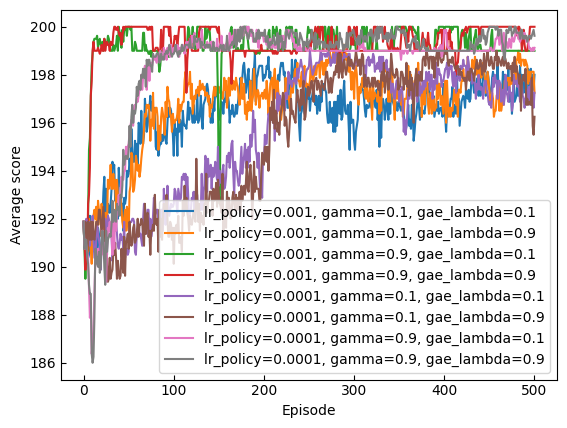

In [7]:
import matplotlib.pyplot as plt

configs = [
    {'lr_policy': 1e-3, 'gamma': 0.1, 'gae_lambda': 0.1},
    {'lr_policy': 1e-3, 'gamma': 0.1, 'gae_lambda': 0.9},
    {'lr_policy': 1e-3, 'gamma': 0.9, 'gae_lambda': 0.1},
    {'lr_policy': 1e-3, 'gamma': 0.9, 'gae_lambda': 0.9},
    {'lr_policy': 1e-4, 'gamma': 0.1, 'gae_lambda': 0.1},
    {'lr_policy': 1e-4, 'gamma': 0.1, 'gae_lambda': 0.9},
    {'lr_policy': 1e-4, 'gamma': 0.9, 'gae_lambda': 0.1},
    {'lr_policy': 1e-4, 'gamma': 0.9, 'gae_lambda': 0.9},
    # add more configurations if needed
]

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 10

for config in configs:
    print(config)
    mean_rewards, loss = train(500, 'CartPole-v1', **config)
    plt.plot(mean_rewards, label=f'ppo learning rate={config["lr_policy"]}, gamma={config["gamma"]}, gae_lambda={config["gae_lambda"]}')

plt.ylabel('Average score')
plt.xlabel('Episode')
plt.legend()
plt.show()


## MountainCar

In [14]:
# mean_rewards, loss = train(500,'MountainCar-v0')

In [15]:
# import matplotlib.pyplot as plt

# plt.rcParams['xtick.direction'] = 'in'
# plt.rcParams['ytick.direction'] = 'in'
# plt.rcParams['font.size'] = 10
# plt.plot(mean_rewards)
# plt.ylabel('Average score')
# plt.xlabel('episode')
# plt.show()

{'lr_policy': 0.001, 'gamma': 0.1, 'gae_lambda': 0.1}


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so 

------------------
Policy(
  (main_net): FCNet(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (fc_actor): Linear(in_features=64, out_features=3, bias=True)
  (fc_critic): Linear(in_features=64, out_features=1, bias=True)
)
------------------
Episode 0	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 100	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 200	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 300	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 400	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 500	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
{'lr_policy': 0.001, 'gamma': 0.1, 'gae_lambda': 0.9}


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8`

------------------
Policy(
  (main_net): FCNet(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (fc_actor): Linear(in_features=64, out_features=3, bias=True)
  (fc_critic): Linear(in_features=64, out_features=1, bias=True)
)
------------------
Episode 0	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 100	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 200	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 300	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 400	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 500	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
{'lr_policy': 0.001, 'gamma': 0.9, 'gae_lambda': 0.1}


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8`

------------------
Policy(
  (main_net): FCNet(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (fc_actor): Linear(in_features=64, out_features=3, bias=True)
  (fc_critic): Linear(in_features=64, out_features=1, bias=True)
)
------------------
Episode 0	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 100	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 200	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 300	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 400	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 500	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
{'lr_policy': 0.001, 'gamma': 0.9, 'gae_lambda': 0.9}


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


------------------
Policy(
  (main_net): FCNet(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (fc_actor): Linear(in_features=64, out_features=3, bias=True)
  (fc_critic): Linear(in_features=64, out_features=1, bias=True)
)
------------------


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8`

Episode 0	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 100	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 200	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 300	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 400	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 500	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
{'lr_policy': 0.0001, 'gamma': 0.1, 'gae_lambda': 0.1}


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


------------------
Policy(
  (main_net): FCNet(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (fc_actor): Linear(in_features=64, out_features=3, bias=True)
  (fc_critic): Linear(in_features=64, out_features=1, bias=True)
)
------------------


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8`

Episode 0	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 100	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 200	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 300	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 400	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 500	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
{'lr_policy': 0.0001, 'gamma': 0.1, 'gae_lambda': 0.9}


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


------------------
Policy(
  (main_net): FCNet(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (fc_actor): Linear(in_features=64, out_features=3, bias=True)
  (fc_critic): Linear(in_features=64, out_features=1, bias=True)
)
------------------


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8`

Episode 0	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 100	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 200	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 300	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 400	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 500	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
{'lr_policy': 0.0001, 'gamma': 0.9, 'gae_lambda': 0.1}


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


------------------
Policy(
  (main_net): FCNet(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (fc_actor): Linear(in_features=64, out_features=3, bias=True)
  (fc_critic): Linear(in_features=64, out_features=1, bias=True)
)
------------------


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8`

Episode 0	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 100	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 200	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 300	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 400	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 500	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
{'lr_policy': 0.0001, 'gamma': 0.9, 'gae_lambda': 0.9}


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8`

------------------
Policy(
  (main_net): FCNet(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (fc_actor): Linear(in_features=64, out_features=3, bias=True)
  (fc_critic): Linear(in_features=64, out_features=1, bias=True)
)
------------------
Episode 0	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 100	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 200	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 300	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 400	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]
Episode 500	Average Score: -200.00
[-200. -200. -200. -200. -200. -200. -200. -200.]


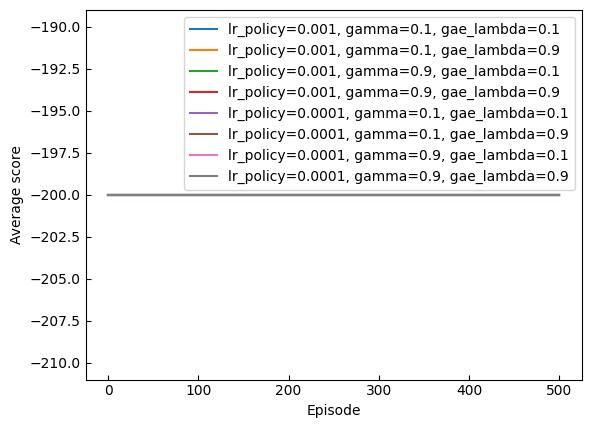

In [16]:
import matplotlib.pyplot as plt

configs = [
    {'lr_policy': 1e-3, 'gamma': 0.1, 'gae_lambda': 0.1},
    {'lr_policy': 1e-3, 'gamma': 0.1, 'gae_lambda': 0.9},
    {'lr_policy': 1e-3, 'gamma': 0.9, 'gae_lambda': 0.1},
    {'lr_policy': 1e-3, 'gamma': 0.9, 'gae_lambda': 0.9},
    {'lr_policy': 1e-4, 'gamma': 0.1, 'gae_lambda': 0.1},
    {'lr_policy': 1e-4, 'gamma': 0.1, 'gae_lambda': 0.9},
    {'lr_policy': 1e-4, 'gamma': 0.9, 'gae_lambda': 0.1},
    {'lr_policy': 1e-4, 'gamma': 0.9, 'gae_lambda': 0.9},
    # add more configurations if needed
]

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 10

for config in configs:
    print(config)
    mean_rewards, loss = train(500,'MountainCar-v0', **config)
    plt.plot(mean_rewards, label=f'lr_policy={config["lr_policy"]}, gamma={config["gamma"]}, gae_lambda={config["gae_lambda"]}')

plt.ylabel('Average score')
plt.xlabel('Episode')
plt.legend()
plt.show()
